In [1]:
import numpy as np
import scanpy as sc
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#import cell2location
import scvi
import os
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=float32,force_device=True'
import cell2location
import torch 

Global seed set to 0
/nfs/team297/bs16/tools/conda_envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/nfs/team297/bs16/tools/conda_envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/code')
import useful_functions as uf

In [3]:
def select_slide(adata, s, s_col='sample'):
        r""" This function selects the data for one slide from the spatial anndata object.

        :param adata: Anndata object with multiple spatial experiments
        :param s: name of selected experiment
        :param s_col: column in adata.obs listing experiment name for each location
        """

        slide = adata[adata.obs[s_col].isin([s]), :]
        s_keys = list(slide.uns['spatial'].keys())
        s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

        slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
        return slide

In [4]:
results_folder = '/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/cell2location'
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/glomTI_snRNAseq_reference_signature'
run_name = f'{results_folder}/healthy_kidney_visium_cell2location_map' #### this is the output dir

In [5]:
os.chdir('/lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response')
adata = sc.read_h5ad('data/raw/visium/kidney_visium.h5ad') #read in the kidney cytassist visium data.. 

In [6]:
#subset to disease biopsies and healthy kidneys.
adata = adata[adata.obs['donor'].isin(['BW2', 'BW3_BW5', 'BW4', 'BW6_BW1', 'K291','K292','K294','K295','K296'])] #just path samples

In [7]:
os.listdir(ref_run_name)

['cell_to_location_reference.h5ad', 'model.pt']

In [8]:
adata_ref = sc.read_h5ad(f"{ref_run_name}/cell_to_location_reference.h5ad")

In [9]:
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File                                                                                                      
         /lustre/scratch126/cellgen/team297/bs16/current_projects/kidney_glomTI_response/data/cell2location/glomTI_
         snRNAseq_reference_signature/model.pt already downloaded                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team297/bs16/tools/conda_envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/361:   0%|▎                                                                                                        | 1/361 [00:00<00:54,  6.57it/s, v_num=1, elbo_train=5.16e+8]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/361:   0%|▎                                                                                                        | 1/361 [00:00<00:57,  6.29it/s, v_num=1, elbo_train=5.16e+8]


In [10]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

podocyte      GPEC  convoluted_PTEC  straight_PTEC  injured_PTEC
LINC01409  0.028051  0.031983         0.021639       0.013327      0.042961
FAM87B     0.001789  0.001932         0.000198       0.001079      0.000530
SAMD11     0.106461  0.029973         0.001055       0.000763      0.000765
NOC2L      0.023529  0.029602         0.038050       0.021010      0.041007
HES4       0.019314  0.023867         0.000476       0.000538      0.008863

In [11]:
# find shared genes and subset both anndata and reference signatures
intersect_features = np.intersect1d(adata.var_names, inf_aver.index)
print(len(intersect_features))
adata = adata[:, intersect_features].copy()
inf_aver = inf_aver.loc[intersect_features, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata, batch_key="sample", layer = 'counts')

10905


In [12]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata, 
    cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=10,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()


Anndata setup with scvi-tools version 0.19.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  10   │
│         n_cells          │ 54875 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 10905 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                                              batch State Registry                                              
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃                            Categories                            ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │   spaceranger210_count_47441_CZI_A_KIDsp13768133_GRCh38-2020-A   │          0          │
│                     │   spaceranger210_count_47441_CZI_A_KIDsp13768134_GRCh38-2020-A   │          1          │
│                     │   spaceranger210_count_47441_CZI_A_KIDsp13768137_GRCh38-2020-A   │          2          │
│                     │ spaceranger210_count_47441_CZI_A_KIDsp13768138_x10_GRCh38-2020-A │          3          │
│                     │   spaceranger210_count_47441_CZI_A_KIDsp13768139_GRCh38-2020-A   │          4          │
│                     │   spaceranger210_count_47441_CZI_A_KIDsp13768140_GRCh38-2020-A   │          5          │
│                     │   spaceranger210_count_47441_CZI_D_KIDsp13768229_GRCh38-2020-A   │          6          │
│                     │   spaceranger210_count_47441_CZI_D_KIDsp13768230_GRCh38-2020-A   │          7          │
│                     │   spaceranger210_count_47747_CZI_D_KIDsp13813009_GRCh38-2020-A   │          8          │
│                     │   spaceranger210_count_47747_CZI_D_KIDsp13813010_GRCh38-2020-A   │          9          │
└─────────────────────┴──────────────────────────────────────────────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/team297/bs16/tools/conda_envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/nfs/team297/bs16/tools/conda_envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 50000/50000: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [3:57:01<00:00,  3.52it/s, v_num=1, elbo_train=5.98e+8]

`Trainer.fit` stopped: `max_epochs=50000` reached.


Epoch 50000/50000: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [3:57:01<00:00,  3.52it/s, v_num=1, elbo_train=5.98e+8]


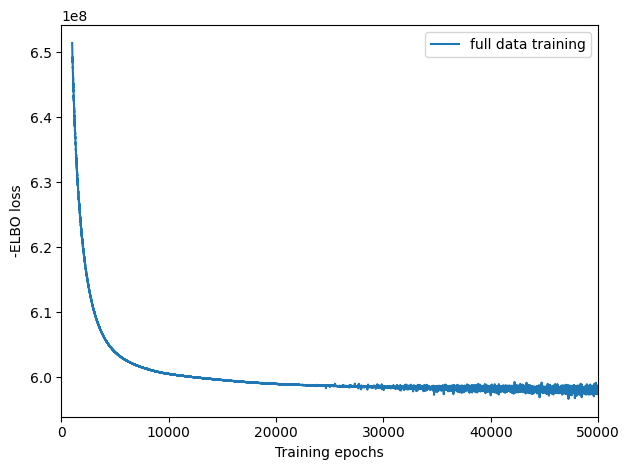

In [13]:
#train the model
mod.train(max_epochs=50000,
           batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);


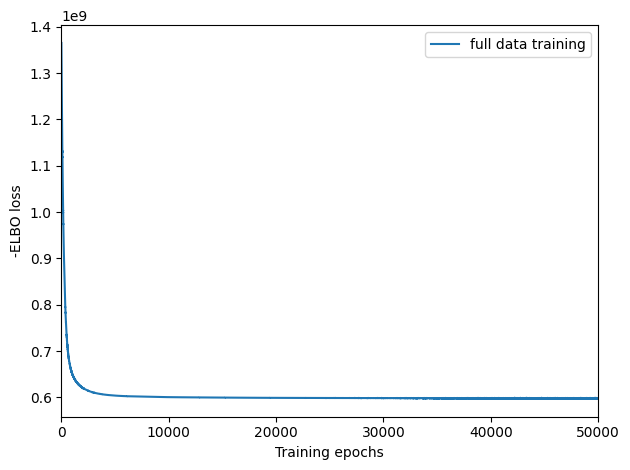

In [14]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history()
plt.legend(labels=['full data training']);


In [15]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata = mod.export_posterior(
    adata, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata.write(adata_file)

Sampling global variables, sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:43<00:00, 22.77it/s]


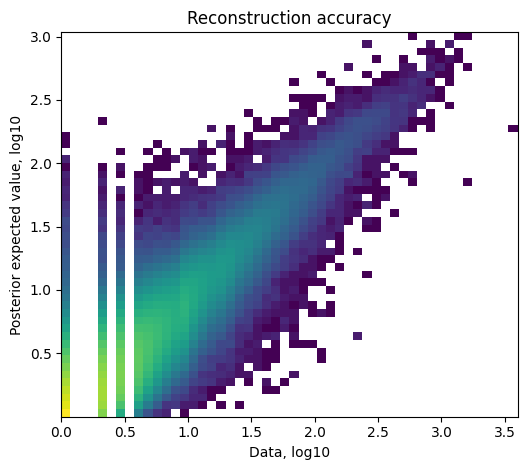

In [16]:
mod.plot_QC()

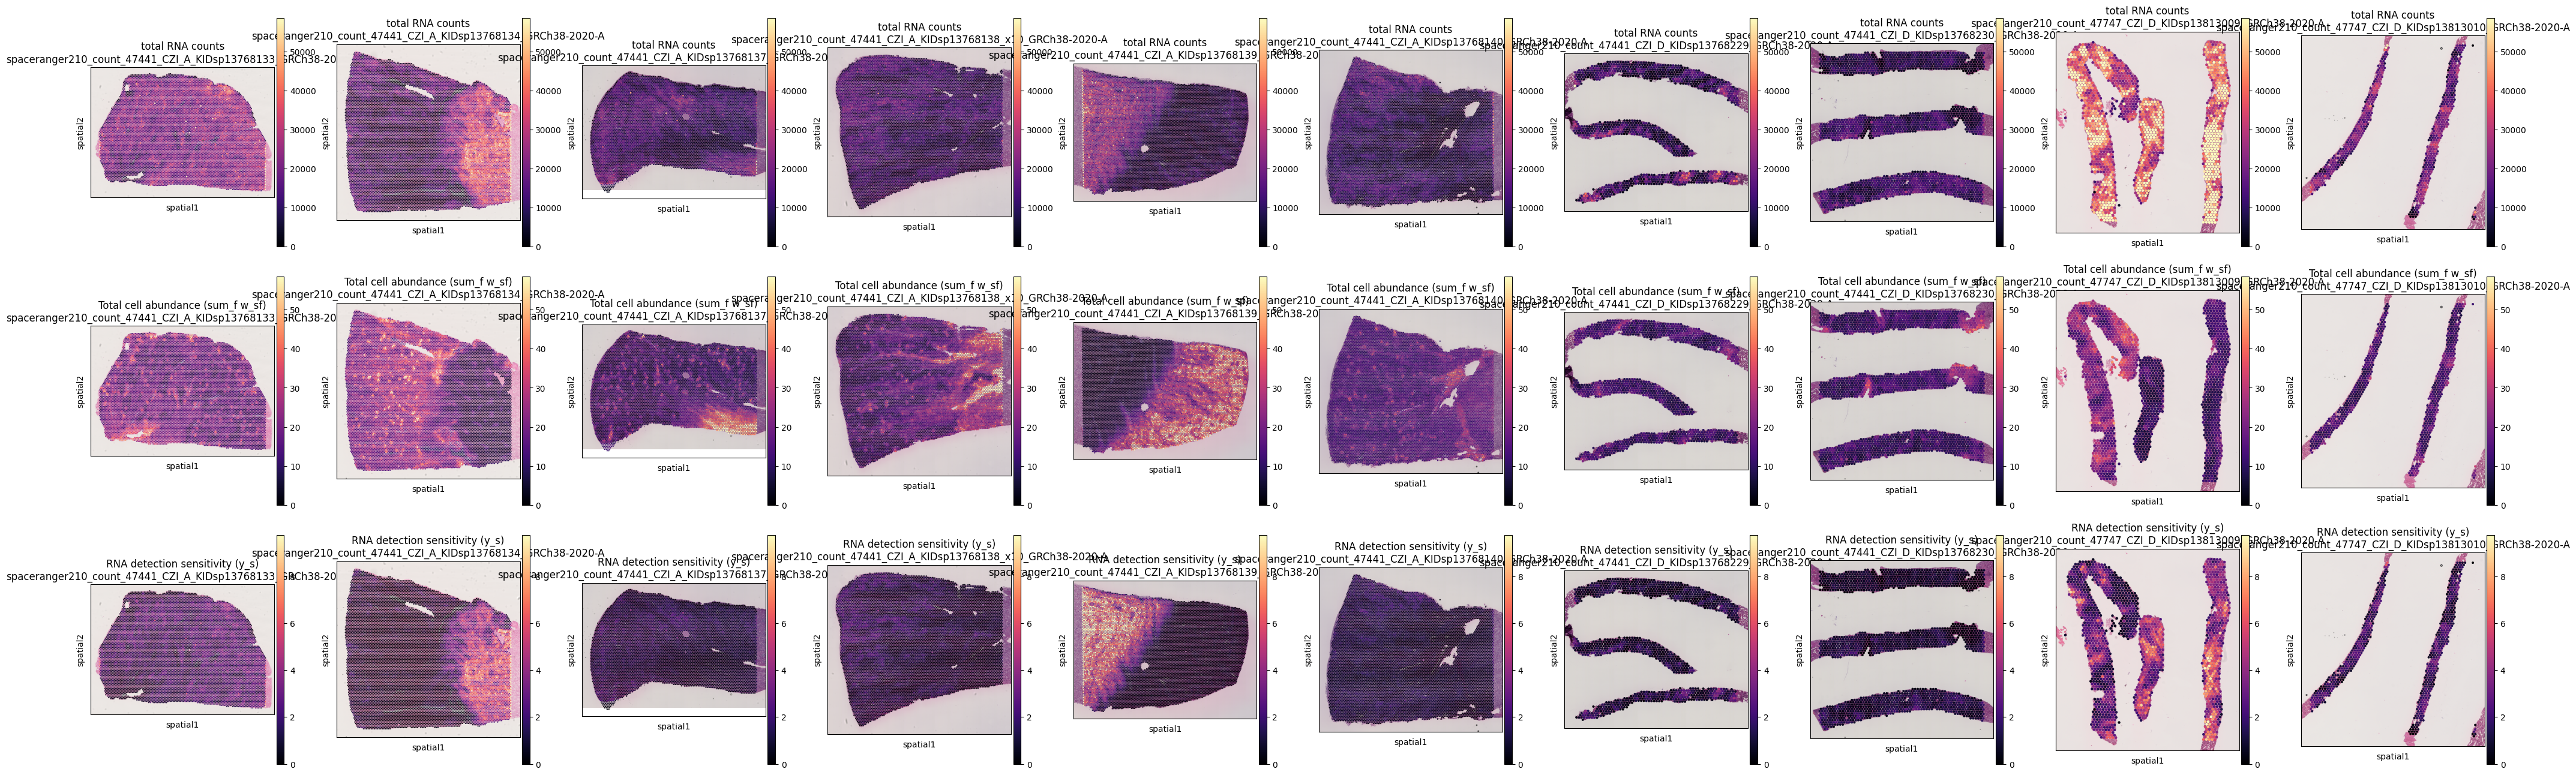

In [17]:
fig = mod.plot_spatial_QC_across_batches()